[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/KMeansClustering.ipynb)

# K-Means clustering
K-means clustering partitions $N$ data-points  into $K$ clusters such that any point is assigned to the cluster with the closest center (*prototype*). The center of each cluster $\mu_k$ is the point minimizing the square of Euclidean distance to every point in the cluster (i.e., the within cluster variance), so the *cost function* is 
$$
J(\{r_{n,k}\},\{\mu_k\}) = \sum_{n=1}^N \sum_{k=1}^K r_{n,k} || x^{(n)} - \mu_k||^2_2 \quad \text{s.t.} \quad \sum_k r_{n,k} = 1,\; r_{n,k} \in {0,1}
$$
 where $r_{n,k}=1$ if the point $n$ is assigned to cluster $k$ and zero otherwise. 
 This is a difficult optimization problem. 
 Our strategy is to start from some assignment to *iteratively optimize $J$* each time keeping either the center or the memberships fixed.
- fixed centers: minimizing $J$ assigns each point to the closest center x
- fixed membership: minimizing $J$ finds the mean of cluster centers. To see why set the derivative of $J$ wrt $\mu_k$ to zero and solve
$$
\frac{\partial}{\partial \mu_k} \sum_n r_{n,k} || x^{(n)} - \mu_k||_2^2 = 2 \sum_n r_{n,k} (x^{(n)} - \mu_k) = 0 \Rightarrow \mu_k = \frac{\sum_n r_{n,k} x^{(n)}}{\sum_n r_{n,k}}
$$

In [7]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [8]:
class KMeans:
    def __init__(self, k=5, max_iters=100, verbose=True):
        self.k = k
        self.max_iters = max_iters
        self.verbose = verbose
    
    def fit(self, x):
        n,d = x.shape
        init_centers = np.random.choice(n, self.k, replace=False)
        mu = x[init_centers]
        for t in range(self.max_iters):
            distances = np.sum((mu[None,:,:] - x[:,None,:])**2, -1) # n x k
            membership = np.argmin(distances, 1)
            mu_new = mu.copy()
            for i in range(self.k):
                mu_new[i,:] = np.mean(x[membership==i], 0)
            if np.allclose(mu_new, mu):
                if self.verbose:
                    print(f'converged after {t} iterations, cost {np.sum(np.min(distances,1))}')
                break
            mu = mu_new
        return mu, membership

There's a problem with this implementaion, can you find it? (what if a center receives no members at all?) can you suggest a fix?

Let's cluster the Iris dataset into 3 clusters (only using 2 features for better visualization)

converged after 8 iterations, cost 37.05070212765958


Text(0.5, 1.0, 'class labels')

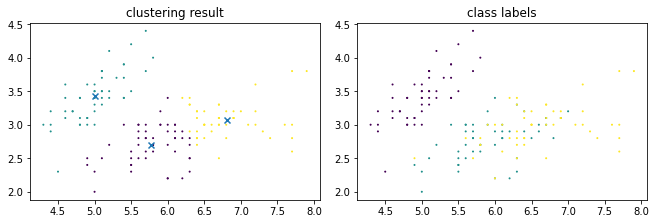

In [10]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,:2], dataset['target']
kmeans = KMeans(3)
mu, cl = kmeans.fit(x)
# plotting the result
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9, 3))
axes[0].scatter(x[:,0], x[:,1], c=cl, s=1)
axes[0].scatter(mu[:,0], mu[:,1], marker='x')
axes[0].set_title('clustering result')
axes[1].scatter(x[:,0], x[:,1], c=y, s=1)
axes[1].set_title('class labels')

There are a variety of solutions for
- choosing $K$
- initializing the cluster centers
- optimizing the cost function above
- improving the time complexity

## Vector Quantization
One of the original applications of K-means is in vector quantization. For example, given an image, K-means enables compression by treating each pixel as a data-point and replacing its value with tht of cluster center. For this example we will use scikit-learn's implementation as it uses `kmeans++` initialization, it does repeated runs and reports the best results, and it is much faster.

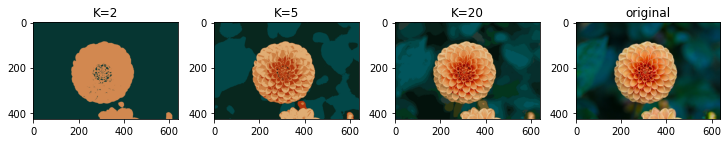

In [6]:
from sklearn.datasets import load_sample_images
import sklearn.cluster

dataset = load_sample_images()
x = dataset.images[1]
kvals = [2,5,20]
fig, axes = plt.subplots(ncols=len(kvals)+1, nrows=1, constrained_layout=True, figsize=(10, 3))
for i, k in enumerate(kvals):
    kmeans = sklearn.cluster.KMeans(n_clusters=k)
    kmeans = kmeans.fit(np.reshape(x, [-1,3]))
    x_rec = np.round(kmeans.cluster_centers_[kmeans.labels_,:]).astype(int)
    x_rec = np.reshape(x_rec, x.shape)
    axes[i].imshow(x_rec)
    axes[i].set_title(f'K={k}')
axes[-1].imshow(x)
axes[-1].set_title('original')
plt.imshow(x)

# K-Medoid clustering
What if our features are not continuous? what if squared Euclidean distance is not the right distance measure?
For some distance functions $\min_{\mu_k} \sum_n \mathrm{dist}(\mu_k, x^{(n)})$ has a closed form solution (e.g., mean for squared Euclidean or median for Manhattan distance); while for some other distances (e.g., Euclidean distance) no such closed form solution exists. One way around this is to assume cluster centers are subsets of the data points. Assuming we can evaluate the distance, optimization above becomes that of *choosing* a member of the cluster as its representative (medoid):
$\min_{n'} \sum_n \mathrm{dist}(x^{(n')}, x^{(n)})$.

In [72]:
euclidean = lambda x1,x2: np.sqrt(np.sum((x1-x2)**2,-1))
manhattan = lambda x1,x2: np.sum(np.abs(x1-x2), -1)
hamming = lambda x1,x2: np.sum((x1!=x2),-1)

class KMedoids:
    
    def __init__(self, K=5, max_iters=100, dist_fn=euclidean, repeats=10):
        self.K = K
        self.max_iters = max_iters
        self.dist_fn = dist_fn
        self.repeats = repeats
    
    def fit(self, x):
        n,d = x.shape
        distances = self.dist_fn(x[None,:,:], x[:,None,:]) # n x n
        best_cost = np.inf
        for r in range(self.repeats):
            medoids = np.random.choice(n, self.K, replace=False)
            for t in range(self.max_iters):
                membership = np.argmin(distances[medoids,:], 0)
                new_medoids = medoids.copy()
                cost = 0
                for i in range(self.K):
                    cluster_inds = np.nonzero(membership == i)[0]
                    cluster_dist = np.sum(distances[np.ix_(cluster_inds, cluster_inds)], 1)
                    cost += np.min(cluster_dist)
                    new_medoids[i] = cluster_inds[np.argmin(cluster_dist)]
                if np.allclose(new_medoids, medoids):
                    #print(f'converged after {t} iterations with the cost {cost}')
                    break
                medoids = new_medoids
            if cost < best_cost:
                best_medoids = medoids
                best_membership = membership
        return best_medoids, best_membership

Let's find K **representative samples** from the `MNIST` dataset.

In [75]:
from sklearn.datasets import fetch_openml
x_org, y = fetch_openml('mnist_784', version=1, return_X_y=True)

(1000, 1000)


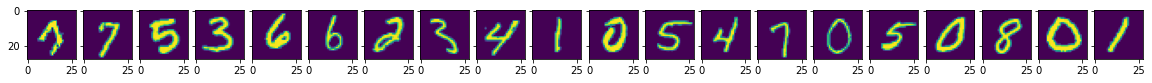

In [78]:
x = x_org[:1000,...]
kmedoid = KMedoids(20, repeats=1000)
centers, _ = kmedoid.fit(x.reshape(-1, 784))
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_digits(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((28,28)))
    plt.show()
plot_digits(x[centers])